In [63]:
import matplotlib.pyplot as plt
import requests
import asyncio
import nest_asyncio
import copy
import numpy as np
import os
import time
nest_asyncio.apply()  # Enable nested asyncio support


In [9]:
docker_url = "http://localhost:5000"

## 10k requests on 3 servers

In [11]:
num_servers = 3
body = {"n": num_servers, "hostnames": ["s1", "s2"]}

res = requests.post(f"{docker_url}/add", json=body)
print(res.json())

{'message': {'N': 3, 'replicas': ['s1', 's2', 'pub_server_1']}, 'status': 'successful'}


In [51]:
num_requests = 10000
server_ids = []


async def make_request():
    res = requests.get(f"{docker_url}/home")
    if res.status_code == 200:
        server_ids.append(int(res.json()["message"][19:]))


async def make_all_requests():
    tasks = [make_request() for _ in range(num_requests)]
    await asyncio.gather(*tasks)


asyncio.get_event_loop().run_until_complete(make_all_requests())

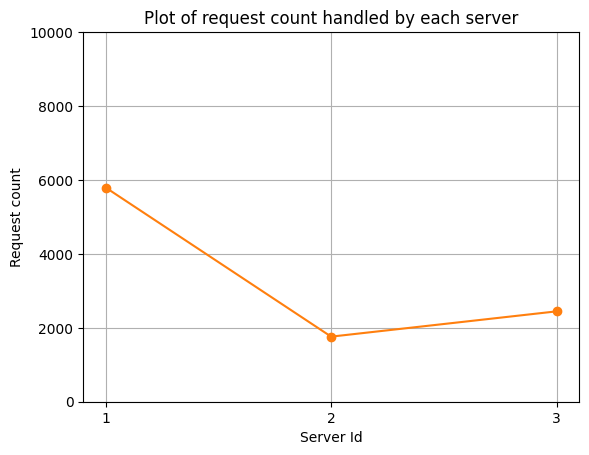

In [16]:
n, x, _ = plt.hist(server_ids, bins=3, alpha=0)
plt.plot([i for i in range(1, num_servers + 1)], n, marker="o", linestyle="-")
plt.ylabel("Request count")
plt.xlabel("Server Id")
plt.xticks([i for i in range(1, num_servers + 1)])
plt.title("Plot of request count handled by each server")
plt.grid(True)
plt.ylim(0, num_requests)
plt.show()

In [17]:
body = {"n": 3, "hostnames": ["s2"]}

res = requests.delete(f"{docker_url}/rm", json=body)
print(res.json())

{'message': {'N': 0, 'replicas': []}, 'status': 'successful'}


## Average load for 10k requests on servers ranging from 2 to 6

In [53]:
body = {"n": 1, "hostnames": ["s1"]}
res = requests.post(f"{docker_url}/add", json=body)

all_server_ids = []

for num_servers in range(2, 7):
    body = {"n": 1, "hostnames": []}
    res = requests.post(f"{docker_url}/add", json=body)
    print(res.json())
    server_ids = []
    asyncio.get_event_loop().run_until_complete(make_all_requests())
    all_server_ids.append(copy.deepcopy(server_ids))
    print(f"Completed for N={num_servers}")

{'message': {'N': 2, 'replicas': ['s1', 'pub_server_2']}, 'status': 'successful'}
Completed for N=2
{'message': {'N': 3, 'replicas': ['s1', 'pub_server_2', 'pub_server_3']}, 'status': 'successful'}
Completed for N=3
{'message': {'N': 4, 'replicas': ['s1', 'pub_server_2', 'pub_server_3', 'pub_server_4']}, 'status': 'successful'}
Completed for N=4
{'message': {'N': 5, 'replicas': ['s1', 'pub_server_2', 'pub_server_3', 'pub_server_4', 'pub_server_5']}, 'status': 'successful'}
Completed for N=5
{'message': {'N': 6, 'replicas': ['s1', 'pub_server_2', 'pub_server_3', 'pub_server_4', 'pub_server_5', 'pub_server_6']}, 'status': 'successful'}
Completed for N=6


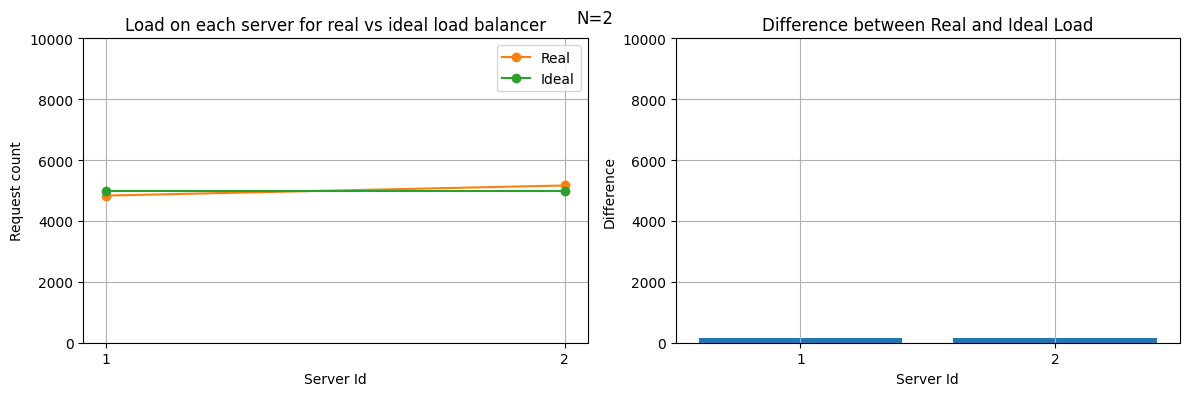

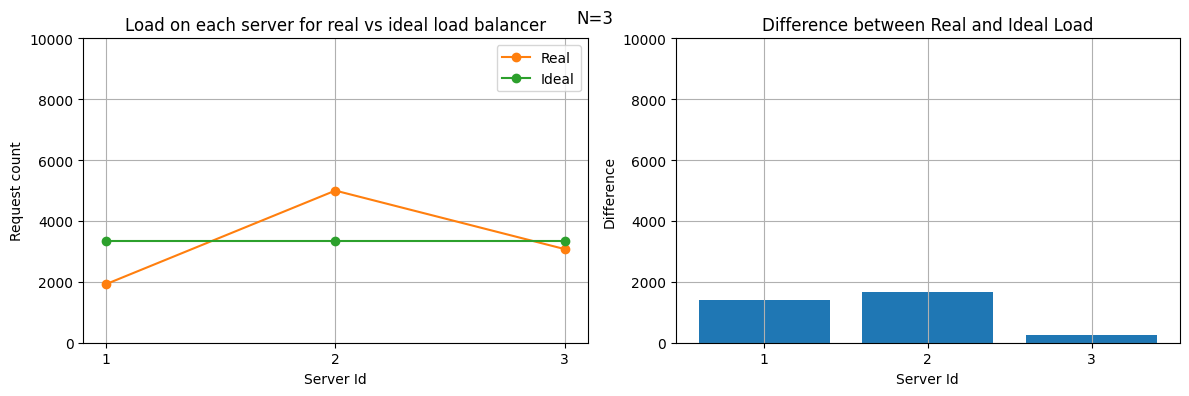

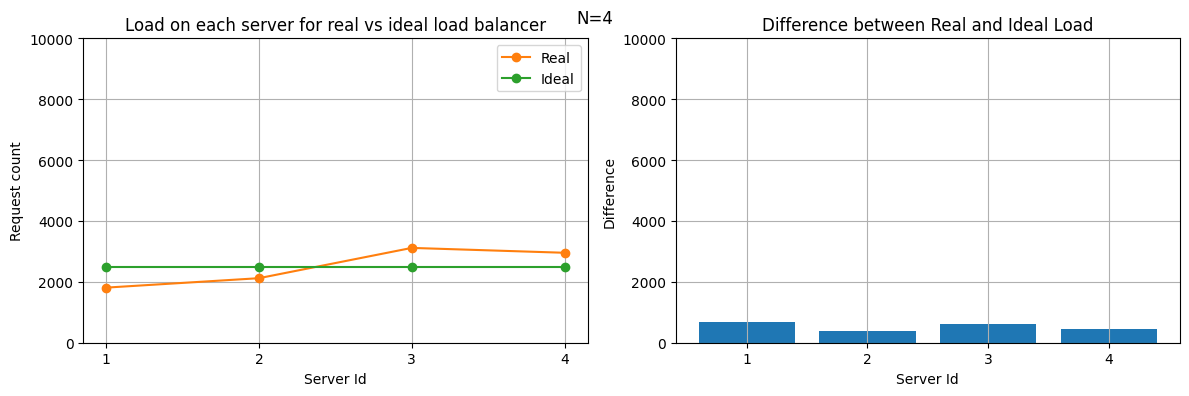

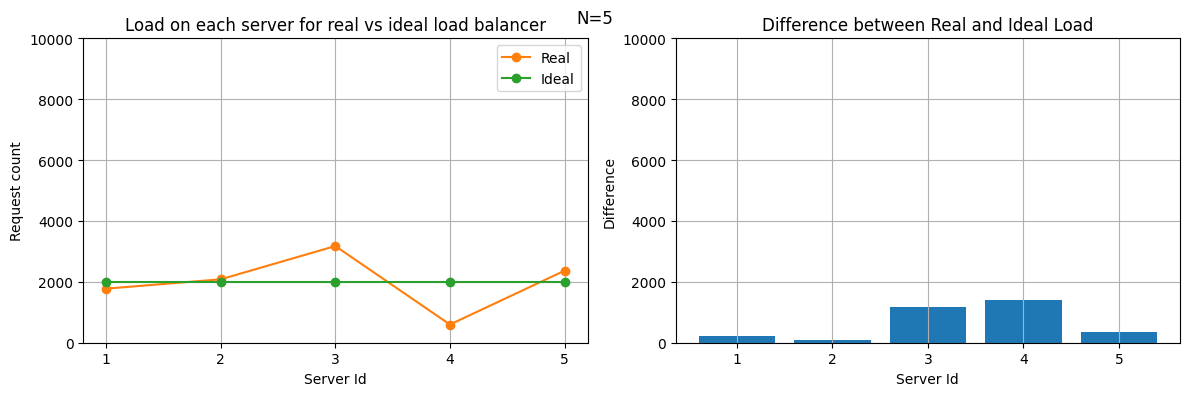

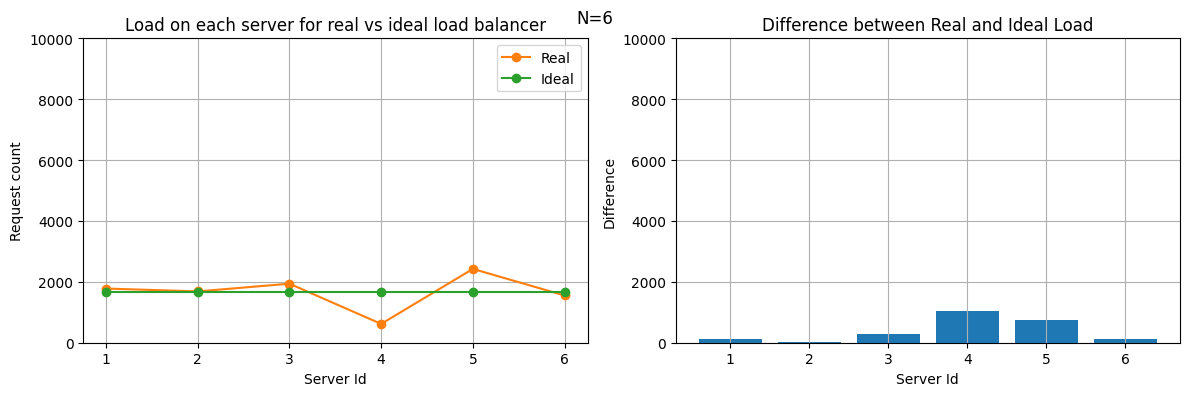

In [55]:
num_servers = 2
for server_ids in all_server_ids:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    n_real, x, _ = plt.hist(server_ids, bins=num_servers, alpha=0)
    n_ideal = [10000 / num_servers for _ in range(num_servers)]
    plt.plot([i for i in range(1, num_servers + 1)], n_real, marker="o", linestyle="-")
    plt.plot(
        [i for i in range(1, num_servers + 1)],
        n_ideal,
        marker="o",
        linestyle="-",
    )
    plt.ylabel("Request count")
    plt.xlabel("Server Id")
    plt.xticks([i for i in range(1, num_servers + 1)])
    plt.title("Load on each server for real vs ideal load balancer")
    plt.grid(True)
    plt.ylim(0, num_requests)
    plt.legend(["Real", "Ideal"])

    plt.subplot(1, 2, 2)
    difference = np.abs(np.array(n_real) - np.array(n_ideal))
    plt.bar([i for i in range(1, num_servers + 1)], difference)
    plt.ylabel("Difference")
    plt.xlabel("Server Id")
    plt.xticks([i for i in range(1, num_servers + 1)])
    plt.title("Difference between Real and Ideal Load")
    plt.grid(True)
    plt.ylim(0, num_requests)

    plt.tight_layout()
    plt.suptitle(f"N={num_servers}")
    plt.show()
    num_servers += 1

In [57]:
res = requests.get(f"{docker_url}/rep").json()
N = res["message"]["N"]
print(N)

body = {"n": N, "hostnames": ["s1"]}
res = requests.delete(f"{docker_url}/rm", json=body)
print(res.json())

6
{'message': {'N': 0, 'replicas': []}, 'status': 'successful'}


## Detecting server failure and recovery

In [69]:
num_servers = 3
body = {"n": num_servers, "hostnames": ["server1", "server2", "server3"]}

res = requests.post(f"{docker_url}/add", json=body)
print(res.json())

{'message': {'N': 3, 'replicas': ['server1', 'server2', 'server3']}, 'status': 'successful'}


In [70]:
# Showing that 3 different respones are being received from 3 servers
distinct_responses = []
while len(distinct_responses) < 3:
    start_time = time.time()
    res = requests.get(f"{docker_url}/home")
    end_time = time.time()
    if res.status_code == 200:
        if res.json()["message"] not in distinct_responses:
            print(
                f"Response: {res.json()['message']}, Time taken: {end_time-start_time} sec"
            )
            distinct_responses.append(res.json()["message"])


Response: Hello from Server: 3, Time taken: 0.07958102226257324 sec
Response: Hello from Server: 1, Time taken: 0.01602911949157715 sec
Response: Hello from Server: 2, Time taken: 0.02766108512878418 sec


In [71]:
# Stopping the container server2
res= os.popen("docker stop server2")

In [72]:
# Showing that even after one server crashed, load balancer spawns new instance when needed
distinct_responses = []
while len(distinct_responses) < 3:
    start_time = time.time()
    res = requests.get(f"{docker_url}/home")
    end_time = time.time()
    if res.status_code == 200:
        if res.json()["message"] not in distinct_responses:
            print(
                f"Response: {res.json()['message']}, Time taken: {end_time-start_time}"
            )
            distinct_responses.append(res.json()["message"])


Response: Hello from Server: 3, Time taken: 0.053414106369018555
Response: Hello from Server: 1, Time taken: 0.011637210845947266
Response: Hello from Server: 4, Time taken: 2.4455389976501465
